In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import matplotlib.pyplot as plt

In [39]:
# generate data for two-mode pidl proof of concept
N = 10000
X = np.random.random(N).astype(np.float32).reshape(-1,1)

In [43]:
# generate Y-data
sign = (- np.ones((N,))).astype(np.float32) ** np.random.randint(2, size=N)
Y = (np.sqrt(X.flatten()) * sign).reshape(-1,1).astype(np.float32)

In [44]:
# torch tensors
X_tensor = torch.tensor(X)
Y_tensor = torch.tensor(Y)

In [47]:
# define nn

class SimpleNN(nn.Module):
    def __init__(self, hiddendim=10):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(1, hiddendim)
        self.fc2 = nn.Linear(hiddendim, hiddendim)
        self.fc3 = nn.Linear(hiddendim, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x) # linear output
        return x

In [48]:
# prepare simple nn
nn_sup = SimpleNN(hiddendim=128)
criterion = nn.MSELoss()
optimizer = optim.Adam(nn_sup.parameters(), lr=0.001)

# train
epochs = 50
batch_size = 5

for epoch in range(epochs):
    permutation = torch.randperm(N)
    epoch_loss = 0.0

    for i in range(0, N, batch_size):
        indices = permutation[i:i+batch_size]
        batch_x, batch_y = X_tensor[indices], Y_tensor[indices]

        optimizer.zero_grad()
        outputs = nn_sup(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if(epoch%10==9): print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/N:.6f}")

Epoch 10/50, Loss: 0.099820
Epoch 20/50, Loss: 0.099816
Epoch 30/50, Loss: 0.099803
Epoch 40/50, Loss: 0.099809
Epoch 50/50, Loss: 0.099794


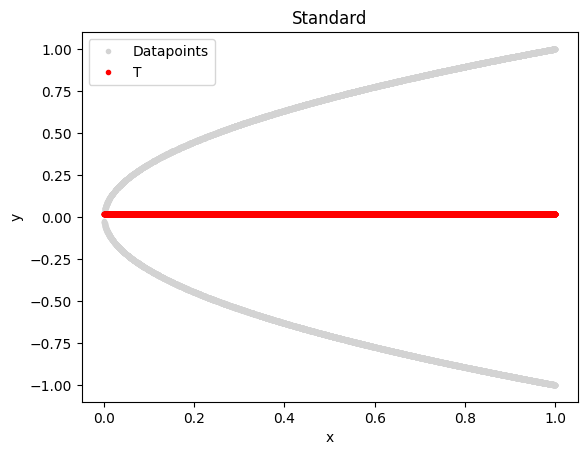

In [49]:
# plot results
plt.plot(X,Y,'.',label='Datapoints', color="lightgray")
plt.plot(X,nn_sup(torch.tensor(X)).detach(), '.',label='T',color="red")
plt.xlabel('x')
plt.ylabel('y')
plt.title('Standard')
plt.legend()
plt.show()

In [50]:
### DIFFERENTIABLE VERSION!!! ###

In [52]:
# X data are the same

# build criterion (loss function)

# P maps Y back onto X by computing a square
# the square op **2 will be differentiable
# because y is a TensorFlow tensor input
def P(y):
    return torch.square(y)

# define custom loss function using "physics" operator P
def loss_function(x_true, y_pred):
    return criterion(x_true, P(y_pred))


# so instead of criterion = MSE(y_true, y_pred)
# we have |(y_pred)^2 - x_true|^2 
# which makes sense because Y = "sqrt(X) * sign"

In [53]:
# instantiate and train
nn_dp = SimpleNN(hiddendim=128)
optimizer = optim.Adam(nn_dp.parameters(), lr=0.001)

# training loop
batch_size = 5

for epoch in range(epochs):
    permutation = torch.randperm(N)
    epoch_loss = 0.0

    for i in range(0, N, batch_size):
        indices = permutation[i:i+batch_size]
        batch_x = X_tensor[indices]

        optimizer.zero_grad()
        outputs = nn_dp(batch_x)
        loss = loss_function(batch_x, outputs)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if(epoch%10==9): print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/N:.6f}")

Epoch 10/50, Loss: 0.000003
Epoch 20/50, Loss: 0.000001
Epoch 30/50, Loss: 0.000003
Epoch 40/50, Loss: 0.000002
Epoch 50/50, Loss: 0.000001
